In [200]:
#Credit card default probability
#Importing useful libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import zipfile
%matplotlib inline

In [250]:
#data preparation
#zf = zipfile.ZipFile('/Users/user/Downloads/UCI_Credit_Card.csv.zip') 
#default = pd.read_csv(zf.open('UCI_Credit_Card.csv'))
default = pd.read_csv('/Users/user/Downloads/Python-Data-Science-and-Machine-Learning-Bootcamp/Credit card default prediction using python/creditcard_defaultv1.csv',index_col="ID")

#default.rename(columns=lambda X: X.lower(), inplace=True)
#Base values: female, other_education, not_married
default['grad_school'] = (default['EDUCATION'] == 1).astype('int')
default['university'] = (default['EDUCATION'] == 2).astype('int')
default['high_school'] = (default['EDUCATION'] == 3).astype('int')
#default['others'] = (default['EDUCATION'] == 4).astype('int')
default.drop('EDUCATION' , axis=1, inplace=True)

default['male'] = (default['SEX']==1).astype('int')
default.drop('SEX' , axis=1, inplace=True)

default['married'] = (default['MARRIAGE']==1).astype('int')
default.drop('MARRIAGE' , axis=1, inplace=True)
# For pay features if the value is <=0 then it means payment was not delayed
pay_features = ['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']
for p in pay_features:
    default.loc[default[p]<=0,p]=0
    default.rename(columns={'default payment next month': 'default'}, inplace=True)
default.head()

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default,grad_school,university,high_school,male,married
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,24,2,2,0,0,0,0,3913,3102,...,0,0,0,0,1,0,0,0,0,0
2,120000,26,0,2,0,0,0,2,2682,1725,...,1000,1000,0,2000,1,0,0,0,0,0
3,90000,34,0,0,0,0,0,0,29239,14027,...,1000,1000,1000,5000,0,0,0,0,0,0
4,50000,37,0,0,0,0,0,0,46990,48233,...,1200,1100,1069,1000,0,0,0,0,0,0
5,50000,57,0,0,0,0,0,0,8617,5670,...,10000,9000,689,679,0,0,0,0,0,0


In [251]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import RobustScaler

In [252]:
target_name = 'default'
X = default.drop('default', axis=1)
robust_scaler = RobustScaler()
X = robust_scaler.fit_transform(X)
y = default[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=123, stratify=y)

In [253]:
def CMatrix(CM, labels=['pay','default']):
    df = pd.DataFrame(data=CM, index=labels, columns=labels)
    df.index.name='TRUE'
    df.columns.name='PREDICTION'
    df.loc['Total']=df.sum()
    df['Total']= df.sum(axis=1)
    return df


In [254]:
# Dataframe for model analysis
metrics = pd.DataFrame(index=['accuracy', 'precision', 'recall'],
                      columns=['Null','LogisticReg','classTree','NaiveBayes'])

In [255]:
# Accuracy - Overall how often model predicts correctly defaulters and non-defaulters
# Precision - When model predict DEFAULT: how often is it correct
# Recall - The proporation of actual defaulters that model will correctly predict as such
# Which metrics should I use?
# False positive - A person who will pay predicted as defaulter
# False negative - A person who default predicted as payer
#False negatives are worst ==> look for better recall

In [256]:
# The Null model: always predicts the most common category
y_pred_test = np.repeat(y_train.value_counts().idxmax(),y_test.size)
metrics.loc['accuracy','NULL'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','NULL'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','NULL'] = recall_score(y_pred=y_pred_test, y_true=y_test)

CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
CMatrix(CM)

/Users/user/anaconda3/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


PREDICTION,pay,default,Total
TRUE,,,
pay,3505,0,3505
default,995,0,995
Total,4500,0,4500


In [257]:
# Logistic Regression
# 1. Import the estimator object(model)
from sklearn.linear_model import LogisticRegression

# 2. Create an instance of the estimator
logistic_regression = LogisticRegression(n_jobs=-1, random_state=15)

# 3. Use the training data to train the estimator
logistic_regression.fit(X_train, y_train)

# 4. Evaluate the model
y_pred_test = logistic_regression.predict(X_test)
metrics.loc['accuracy','LogisticReg'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','LogisticReg'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','LogisticReg'] = recall_score(y_pred=y_pred_test, y_true=y_test)
# Confusion matrix
CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
CMatrix(CM)


/Users/user/anaconda3/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


PREDICTION,pay,default,Total
TRUE,,,
pay,3368,137,3505
default,669,326,995
Total,4037,463,4500


In [258]:
# Classification Trees

# 1. Import the estimator object(model)
from sklearn.tree import DecisionTreeClassifier

# 2. Create an instance of the estimator
class_tree = DecisionTreeClassifier(min_samples_split=30, min_samples_leaf=10, random_state=10)

# 3. Use the training data to train the estimator
class_tree.fit(X_train, y_train)

# 4. Evaluate the model
y_pred_test = class_tree.predict(X_test)
metrics.loc['accuracy','ClassTree'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','ClassTree'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','ClassTree'] = recall_score(y_pred=y_pred_test, y_true=y_test)
# Confusion matrix
CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
CMatrix(CM)


PREDICTION,pay,default,Total
TRUE,,,
pay,3174,331,3505
default,644,351,995
Total,3818,682,4500


In [259]:
# Naive Bayes Classifier

# 1. Import the estimator object(model)
from sklearn.naive_bayes import GaussianNB

# 2. Create an instance of the estimator
NBC = GaussianNB()

# 3. Use the training data to train the estimator
NBC.fit(X_train, y_train)

# 4. Evaluate the model
y_pred_test = NBC.predict(X_test)
metrics.loc['accuracy','NaiveBayes'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','NaiveBayes'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','NaiveBayes'] = recall_score(y_pred=y_pred_test, y_true=y_test)
# Confusion matrix
CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
CMatrix(CM)

PREDICTION,pay,default,Total
TRUE,,,
pay,2899,606,3505
default,436,559,995
Total,3335,1165,4500


In [260]:
100*metrics

,Null,LogisticReg,classTree,NaiveBayes,NULL,ClassTree
accuracy,NaN,82.0889,NaN,76.8444,77.888889,78.333333
precision,NaN,70.4104,NaN,47.9828,0.000000,51.466276
recall,NaN,32.7638,NaN,56.1809,0.000000,35.276382


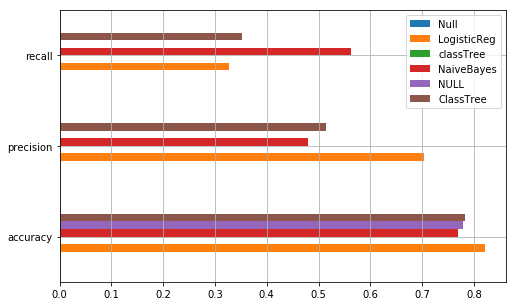

In [261]:
fig, ax = plt.subplots(figsize=(8,5))
metrics.plot(kind='barh',ax=ax)
ax.grid();

In [262]:
precision_nb, recall_nb, thresholds_nb = precision_recall_curve(y_true=y_test, 
                                                                probas_pred=NBC.predict_proba(X_test)[:,1])
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_true=y_test, 
                                                                probas_pred=logistic_regression.predict_proba(X_test)[:,1])

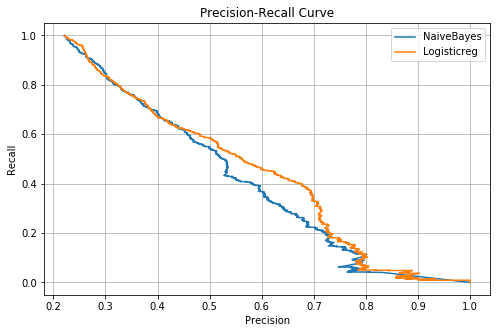

In [263]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(precision_nb, recall_nb, label='NaiveBayes')
ax.plot(precision_lr, recall_lr, label='Logisticreg')
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.set_title('Precision-Recall Curve')
#ax.hlines(y=0.5, xmin=0, xmax=1, color='Red')
ax.legend()
ax.grid();

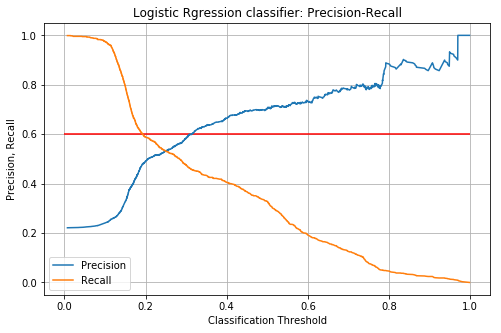

In [264]:
# Confusion matrix for modified logistic regression classifier

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(thresholds_lr, precision_lr[1:], label='Precision')
ax.plot(thresholds_lr, recall_lr[1:], label='Recall')
ax.set_xlabel('Classification Threshold')
ax.set_ylabel('Precision, Recall')
ax.set_title('Logistic Rgression classifier: Precision-Recall')
ax.hlines(y=0.6, xmin=0, xmax=1, color='Red')
ax.legend()
ax.grid();

In [265]:
# Classifier with threshold 0.2

y_pred_proba = logistic_regression.predict_proba(X_test)[:,1]
y_pred_test = (y_pred_proba >= 0.2).astype('int')
#Confusion Matrix
CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
print("Recall: ", 100*recall_score(y_pred=y_pred_test, y_true=y_test))
print("Precision: ", 100*precision_score(y_pred=y_pred_test, y_true=y_test))
CMatrix(CM)

Recall:  58.79396984924623
Precision:  48.95397489539749


PREDICTION,pay,default,Total
TRUE,,,
pay,2895,610,3505
default,410,585,995
Total,3305,1195,4500


In [266]:
# Making individual predictions

def make_ind_prediction(new_data):
    data = new_data.values.reshape(1,-1)
    data = robust_scaler.transform(data)
    prob = logistic_regression.predict_proba(data)[0][1]
    if prob >=0.2:
        return 'Will default'
    else:
        return 'Will pay'

In [267]:
pay = default[default['default']==0]

In [268]:
pay.head()

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default,grad_school,university,high_school,male,married
ID,,,,,,,,,,,,,,,,,,,,,
3,90000,34,0,0,0,0,0,0,29239,14027,...,1000,1000,1000,5000,0,0,0,0,0,0
4,50000,37,0,0,0,0,0,0,46990,48233,...,1200,1100,1069,1000,0,0,0,0,0,0
5,50000,57,0,0,0,0,0,0,8617,5670,...,10000,9000,689,679,0,0,0,0,0,0
6,50000,37,0,0,0,0,0,0,64400,57069,...,657,1000,1000,800,0,0,0,0,0,0
7,500000,29,0,0,0,0,0,0,367965,412023,...,38000,20239,13750,13770,0,0,0,0,0,0


In [269]:
from collections import OrderedDict
new_customer = OrderedDict([('LIMIT_BAL', 4000),('AGE', 50),('BILL_AMT1', 500),
                           ('BILL_AMT2', 35509),('BILL_AMT3', 689),('BILL_AMT4', 0),
                           ('BILL_AMT5', 0),('BILL_AMT6', 0),('PAY_AMT1',0),('PAY_AMT2',35509),
                           ('PAY_AMT3',0),('PAY_AMT4',0),('PAY_AMT5',0),('PAY_AMT6',0),
                           ('male', 1),('grad_school', 0),('university',1),('high_school',0),
                           ('married', 1),('PAY_0', -1),('PAY_2', -1),('PAY_3', -1),('PAY_4', 0),
                           ('PAY_5', -1),('PAY_6', 0)])
new_customer = pd.Series(new_customer)
make_ind_prediction(new_customer)

'Will default'